**Chapter 13 – Convolutional Neural Networks**

_This notebook contains all the sample code and solutions to the exercices in chapter 13._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

And of course we will need TensorFlow:

In [3]:
import tensorflow as tf

# Convolutional layer

In [4]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

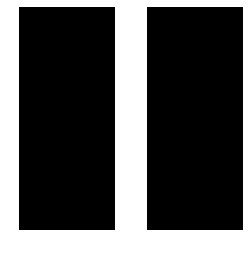

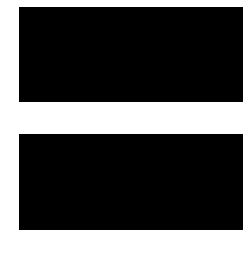

In [5]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
fmap[:, :, 0, 0]
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

In [6]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME", use_cudnn_on_gpu=False)

In [7]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

Saving figure china_original


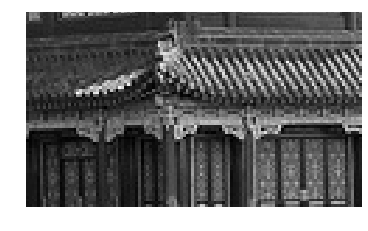

In [8]:
plot_image(images[0, :, :, 0])
save_fig("china_original", tight_layout=False)
plt.show()

Saving figure china_vertical


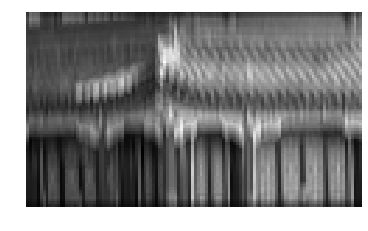

In [9]:
plot_image(output[0, :, :, 0])
save_fig("china_vertical", tight_layout=False)
plt.show()

Saving figure china_horizontal


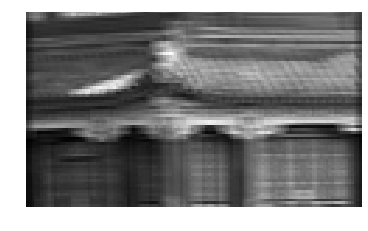

In [10]:
plot_image(output[0, :, :, 1])
save_fig("china_horizontal", tight_layout=False)
plt.show()

## Simple example

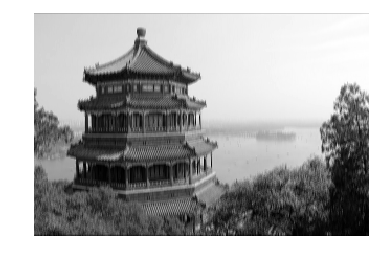

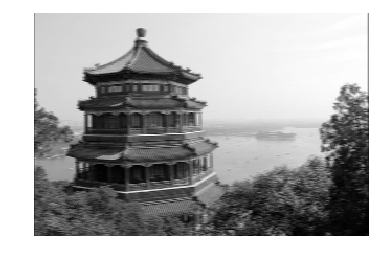

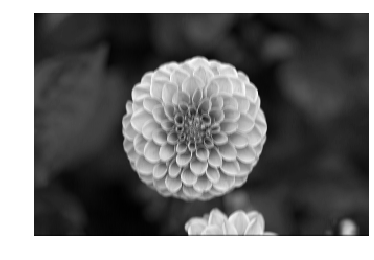

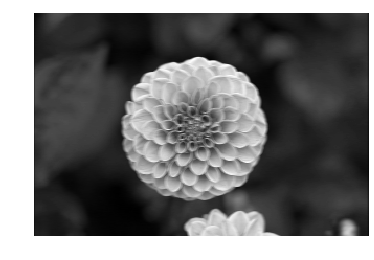

In [11]:
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

## VALID vs SAME padding

In [12]:
tf.reset_default_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

VALID:
 [[[[ 184.]
   [ 389.]]]]
SAME:
 [[[[ 143.]
   [ 348.]
   [ 204.]]]]


In [13]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))


VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


# Pooling layer

Saving figure china_original


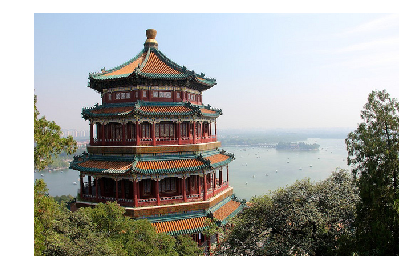

Saving figure china_max_pool


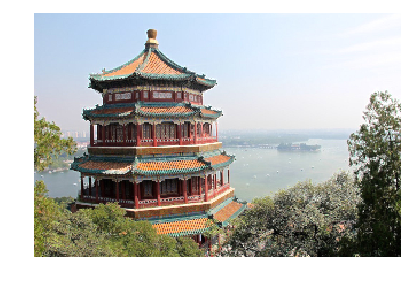

In [14]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plot_color_image(dataset[0])
save_fig("china_original")
plt.show()
    
plot_color_image(output[0])
save_fig("china_max_pool")
plt.show()

# MNIST

Note: instead of using the `fully_connected()`, `conv2d()` and `dropout()` functions from the `tensorflow.contrib.layers` module (as in the book), we now use the `dense()`, `conv2d()` and `dropout()` functions (respectively) from the `tf.layers` module, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same.

For all these functions:
* the `scope` parameter was renamed to `name`, and the `_fn` suffix was removed in all the parameters that had it (for example the `activation_fn` parameter was renamed to `activation`).

The other main differences in `tf.layers.dense()` are:
* the `weights` parameter was renamed to `kernel` (and the weights variable is now named `"kernel"` rather than `"weights"`),
* the default activation is `None` instead of `tf.nn.relu`

The other main differences in `tf.layers.conv2d()` are:
* the `num_outputs` parameter was renamed to `filters`,
* the `stride` parameter was renamed to `strides`,
* the default `activation` is now `None` instead of `tf.nn.relu`.

The other main differences in `tf.layers.dropout()` are:
* it takes the dropout rate (`rate`) rather than the keep probability (`keep_prob`). Of course, `rate == 1 - keep_prob`,
* the `is_training` parameters was renamed to `training`.

In [15]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

graph = tf.Graph()
with graph.as_default():
    with tf.name_scope("inputs"):
        X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
        X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
        y = tf.placeholder(tf.int32, shape=[None], name="y")
        is_training = tf.placeholder_with_default(False, shape=[], name='is_training')

    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize, strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu, name="conv1")
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize, strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu, name="conv2")

    with tf.name_scope("pool3"):
        pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
        pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
        pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=is_training)

    with tf.name_scope("fc1"):
        fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
        fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=is_training)

    with tf.name_scope("output"):
        logits = tf.layers.dense(fc1, n_outputs, name="output")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

    with tf.name_scope("train"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
        loss = tf.reduce_mean(xentropy)
        optimizer = tf.train.AdamOptimizer()
        training_op = optimizer.minimize(loss)

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    with tf.name_scope("init_and_save"):
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

In [16]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [17]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [18]:
n_epochs = 1000
batch_size = 50

best_acc_val = 0
check_interval = 100
checks_since_last_progress = 0
max_checks_without_progress = 100
best_model_params = None 

with tf.Session(graph=graph) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, is_training: True})
            if iteration % check_interval == 0:
                acc_val = accuracy.eval(feed_dict={X: mnist.test.images[:2000], y: mnist.test.labels[:2000]})
                if acc_val > best_acc_val:
                    best_acc_val = acc_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images[2000:], y: mnist.test.labels[2000:]})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test, "Best validation accuracy:", best_acc_val)
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: mnist.test.images[2000:], y: mnist.test.labels[2000:]})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, "./my_mnist_model")

0 Train accuracy: 1.0 Test accuracy: 0.981 Best validation accuracy: 0.978
1 Train accuracy: 1.0 Test accuracy: 0.989625 Best validation accuracy: 0.986
2 Train accuracy: 1.0 Test accuracy: 0.988125 Best validation accuracy: 0.986
3 Train accuracy: 0.98 Test accuracy: 0.989125 Best validation accuracy: 0.989
4 Train accuracy: 1.0 Test accuracy: 0.9895 Best validation accuracy: 0.989
5 Train accuracy: 1.0 Test accuracy: 0.99025 Best validation accuracy: 0.989
6 Train accuracy: 1.0 Test accuracy: 0.99 Best validation accuracy: 0.989
7 Train accuracy: 1.0 Test accuracy: 0.9925 Best validation accuracy: 0.989
8 Train accuracy: 1.0 Test accuracy: 0.991875 Best validation accuracy: 0.989
9 Train accuracy: 1.0 Test accuracy: 0.990125 Best validation accuracy: 0.989
10 Train accuracy: 1.0 Test accuracy: 0.99025 Best validation accuracy: 0.989
11 Train accuracy: 1.0 Test accuracy: 0.99075 Best validation accuracy: 0.989
12 Train accuracy: 1.0 Test accuracy: 0.990125 Best validation accuracy: 0.

# Inception v3

In [21]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [22]:
fetch_pretrained_inception_v3()

In [23]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets","inception","imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [24]:
class_names = load_class_names()

In [25]:
width = 299
height = 299
channels = 3

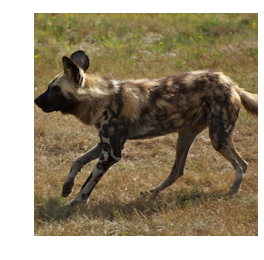

In [26]:
import matplotlib.image as mpimg
test_image = mpimg.imread(os.path.join("images","cnn","test_image.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [27]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

In [28]:
X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

In [29]:
class_names[np.argmax(predictions_val[0])]

'hyena, hyaena'

In [30]:
np.argmax(predictions_val, axis=1)

array([276])

In [31]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = top_5[np.argsort(predictions_val[0][top_5])]
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100*predictions_val[0][i]))

swing: 0.04%
beer bottle: 0.05%
common newt, Triturus vulgaris: 0.05%
red fox, Vulpes vulpes: 2.36%
hyena, hyaena: 93.85%


# Exercise solutions

**Coming soon**